In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [125]:
dataset = 'Square-Wave' # Mackey-Glass, ECG, EMG, Square-Wave

In [126]:
# load csv files into pandas dataframes
if dataset == 'Mackey-Glass':
    results = pd.read_csv('results_MG.csv', sep=",") 
    targets = pd.read_csv('targets_MG.csv', sep=",")
elif dataset == 'ECG':
    results = pd.read_csv('results_ECG.csv', sep=",")
    targets = pd.read_csv('targets_ECG.csv', sep=",")
elif dataset == 'EMG':
    results = pd.read_csv('sweep_results_EMG.csv', sep=",")
    targets = pd.read_csv('Sweep_targets_EMG.csv', sep=",")
elif dataset == 'Square-Wave':
    results = pd.read_csv('sweep_results_SQUARE.csv', sep=",")
    targets = pd.read_csv('Sweep_targets_SQUARE.csv', sep=",")

In [127]:
# column headers for each dataframe
display(list(results.columns.values)) 
display(list(targets.columns.values)) 
res_col_names = list(results.columns.values)
targ_col_names = list(targets.columns.values)

['transient',
 'rhos',
 'reg',
 'lis',
 'iss',
 'con',
 'Nr',
 'Nl',
 '.sampling',
 'MSE',
 'outputs',
 'MSE_std',
 'outputs_std']

['sampling rate', 'test_targets']

In [128]:
# this function converts a column that contains long string-lists in individual cells to a list of arrays
def make_arr(col_name):
    if col_name == "test_targets":
        outputs = np.array(targets[col_name])
    else:
        samp_sweep = results.loc[results['.sampling'] == 1]
        outputs = np.array(samp_sweep[col_name])

    out_mat = []
    for out in outputs:
        single = out.split(',')
        arr = []

        if col_name == "test_targets":
            for i in range(len(single)):
                if i == 0:
                    arr.append(float(single[i][2:len(single[i])]))
                elif i == len(single)-1:
                    arr.append(float(single[i][0:(len(single[i])-2)]))
                else:
                    arr.append(float(single[i]))
                out_mat.append(arr)

        else:
            for i in range(len(single)):
                if i == 0:
                    arr.append(float(single[i][1:len(single[i])]))
                elif i == len(single)-1:
                    arr.append(float(single[i][0:(len(single[i])-1)]))
                else:
                    arr.append(float(single[i]))
            out_mat.append(arr)

    return out_mat

In [129]:
# this function returns the configuration of a requested index
# included MSE values
# also prints configuration with column names
def get_config(index):
    config = []
    for i in range(9):
        print(res_col_names[i], " = ", results[res_col_names[i]][index])
        config.append(results[res_col_names[i]][index])
    print("self_fed_MSE = ", results[res_col_names[9]][index])
    config.append(results[res_col_names[9]][index])
    print("signal_fed_MSE = ", results[res_col_names[11]][index])
    config.append(results[res_col_names[11]][index])
    return config

In [130]:
# necessary columns to convert for results.csv
# renamed for qualitative clarity
# first index corresponds which configuration is used
self_fed_mat = make_arr("outputs")
signal_fed_mat = make_arr("outputs_std")

In [131]:
# conversion for targets
orig_signal_mat = make_arr("test_targets")

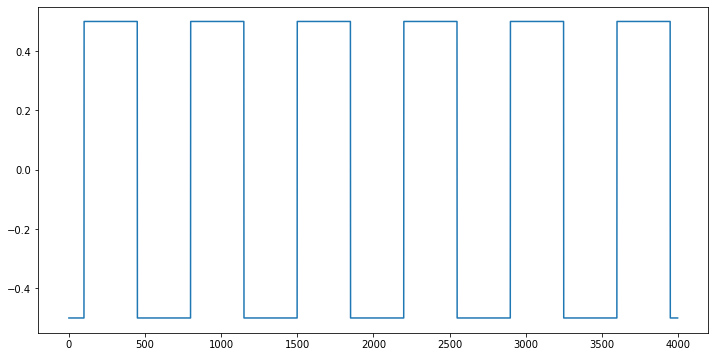

In [132]:
plt.plot(orig_signal_mat[0])
plt.show()

In [133]:
# collect standard deviations

self_fed_std = []
signal_fed_std = []
orig_signal_std = np.std(orig_signal_mat[0])

for i in range(len(self_fed_mat)):
    self_fed_std.append(np.std(self_fed_mat[i]))

for i in range(len(signal_fed_mat)):
    signal_fed_std.append(np.std(signal_fed_mat[i]))

In [134]:
print(f"\nThe std for the original signal is {np.std(orig_signal_mat[0])}\n\n")

print(f"The max std for self-fed is {np.amax(self_fed_std)} at index {np.argmax(self_fed_std)}")
print(f"The max std for signal-fed is {np.amax(signal_fed_std)} at index {np.argmax(signal_fed_std)}\n\n")

print(f"The min std for self-fed is {np.amin(self_fed_std)} at index {np.argmin(self_fed_std)}")
print(f"The min std for signal-fed is {np.amin(signal_fed_std)} at index {np.argmin(signal_fed_std)}\n\n")

print(f"The max MSE for self-fed is {np.amax(results['MSE'])} at index {np.argmax(results['MSE'])}")
print(f"The max MSE for signal-fed is {np.amax(results['MSE_std'])} at index {np.argmax(results['MSE_std'])}\n\n")

print(f"The min MSE for self-fed is {np.amin(results['MSE'])} at index {np.argmin(results['MSE'])}")
print(f"The min MSE for signal-fed is {np.amin(results['MSE_std'])} at index {np.argmin(results['MSE_std'])}")


The std for the original signal is 0.4993680192240846


The max std for self-fed is 24.89644540821153 at index 602
The max std for signal-fed is 1.379743642311602 at index 2113


The min std for self-fed is 0.0 at index 1093
The min std for signal-fed is 0.0 at index 554


The max MSE for self-fed is 27529.38422811368 at index 1983
The max MSE for signal-fed is 2.094728802407487 at index 2113


The min MSE for self-fed is 0.2452822379570174 at index 800
The min MSE for signal-fed is 2.444549431470101e-09 at index 2022


In [135]:
# Here the number of times a given time series rises above a certain threshold is counted
# This is a crude way of counting peaks, which is a defining feature of the series contour
# The threshold itself is selected as a function of the series mean and standard deviation
# A heuristic decision is made for each dataset as to what factor of the standard deviation gives a threshold that is most expressive of model architecture.
# This function is the same as for the original signal, but now can be used to iterate through various models
def peak_finder(set ,index):

    if dataset == 'ECG':
        ostd = np.mean(set[index]) + np.std(set[index])*2
    if dataset == 'EMG':
        ostd = np.mean(set[index]) + np.std(set[index])
    if dataset == 'Square-Wave':
        ostd = np.mean(set[index]) + np.std(set[index])*.5
    if dataset == 'Mackey-Glass':
        ostd = np.mean(set[index]) - np.std(set[index])*2

    count = 0
    for i in range(len(set[index])-1):
        if set[index][i] < ostd and set[index][i+1] > ostd:
            count += 1
    #print(count)
    return count

In [136]:
orig_peaks = peak_finder(orig_signal_mat,0)
print(f"Number of peaks in original signal: {orig_peaks}\n\n")

std_peaks=[]
for i in range(len(self_fed_mat)):
    std_peaks.append(peak_finder(self_fed_mat, i))

peaked = []
if dataset == 'Mackey-Glass':
    for i in range(len(std_peaks)):
        if std_peaks[i] > orig_peaks*(1-.15) and std_peaks[i] < orig_peaks*(1+.15):
            peaked.append(i)
else:
    for i in range(len(std_peaks)):
        if std_peaks[i] > orig_peaks*(1-.5) and std_peaks[i] < orig_peaks*(1+.5):
            peaked.append(i)

print(f"Number of models with peak-count in a similar range: {len(peaked)}\n")

Number of peaks in original signal: 6


Number of models with peak-count in a similar range: 51



In [137]:
# Compile a list of models for a given range of standard deviations
med_fed_std = []
std_orig = np.std(orig_signal_mat[0])
max_orig = np.max(orig_signal_mat[0])
min_orig = np.min(orig_signal_mat[0])

if dataset == "EMG":
    for i in range(len(self_fed_std)):
        if self_fed_std[i] > std_orig*(1-.5) and self_fed_std[i] < std_orig*(1+.5):
            med_fed_std.append(i)

else:
    for i in peaked:
        if self_fed_std[i] > std_orig*(1-.5) and self_fed_std[i] < std_orig*(1+.5) and np.amax(self_fed_mat[i]) < max_orig*(1+.5) and np.amax(self_fed_mat[i]) > max_orig*(1-.5) and np.amin(self_fed_mat[i]) > min_orig*(1+.5) and np.amin(self_fed_mat[i]) < min_orig*(1-.5):
            med_fed_std.append(i)
print(len(med_fed_std))

1


In [139]:
print(med_fed_std)

[1716]


In [140]:
def multi_plot(models):
    for i in models:
        print("Model number: ", i)
        plt.plot(self_fed_mat[i])
        plt.show()
        get_config(i)
        print("\n\n")

In [141]:
def model_comparison(top_models, feed):
    for model in top_models:
        print("Model number: ", model)
        plt.rcParams['figure.figsize'] = [12, 6]
        plt.plot(orig_signal_mat[0], label = "Original")
        plt.title(f"Top {feed}-Fed Model and Original Signal for {dataset} Dataset")

        if feed == 'Self':
            plt.plot(self_fed_mat[model], label = "Self-Fed Prediction")
        elif feed == 'Signal':
            plt.plot(self_fed_mat[model], label = "Signal-Fed Prediction")

        if dataset == 'Mackey-Glass' or dataset == 'Square-Wave':
            plt.xlabel("x")
            plt.ylabel("y")
        elif dataset == 'ECG' or dataset == 'EMG':
            plt.xlabel("Time Steps (700hz)")
            plt.ylabel("mV")

        plt.legend()
        plt.show()
        get_config(model)
        print("\n\n")

Model number:  1716


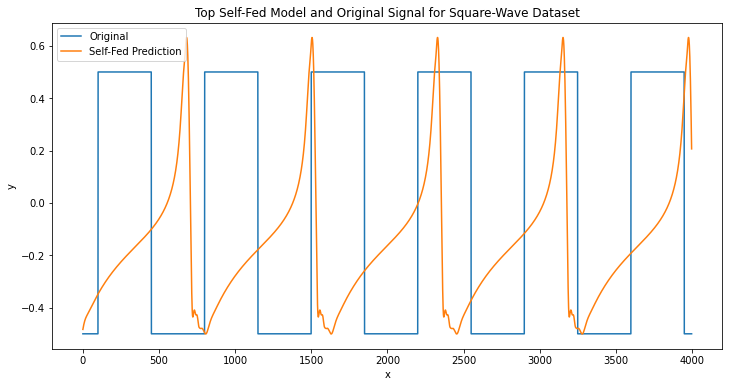

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.2
iss  =  1.0
con  =  0.5
Nr  =  10
Nl  =  10
.sampling  =  1
self_fed_MSE =  0.3586863116646003
signal_fed_MSE =  0.0057959680926629





In [142]:
med_fed_std
model_comparison(med_fed_std, 'Self')

In [143]:
# top model list:
#     ECG: 1331  #, 731
#     EMG: 2143 #1522, 1801  ** all 2000's model perform similar from med_fed_std--note that only std constriant is used
#     Square: 1716, 722
#     Mackey: 2121 # on additional basis of MSE

In [150]:
%%capture cap 
top_models = [1716, 722]
model_comparison(top_models, 'Self')

In [151]:
with open(f'top_models_{dataset}.txt', 'w') as f:
    f.write(cap.stdout)

Model number:  1716


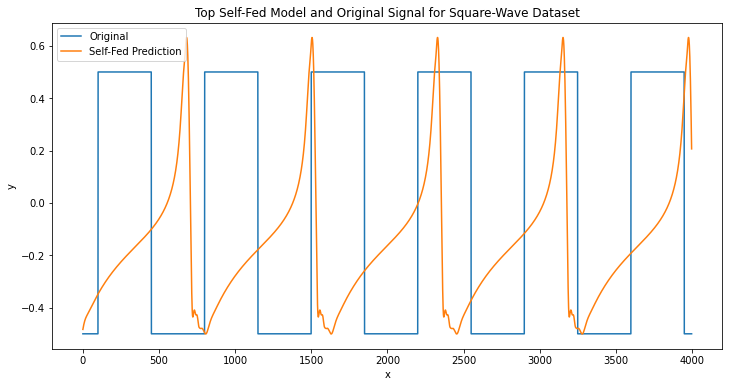

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.2
iss  =  1.0
con  =  0.5
Nr  =  10
Nl  =  10
.sampling  =  1
self_fed_MSE =  0.3586863116646003
signal_fed_MSE =  0.0057959680926629



Model number:  722


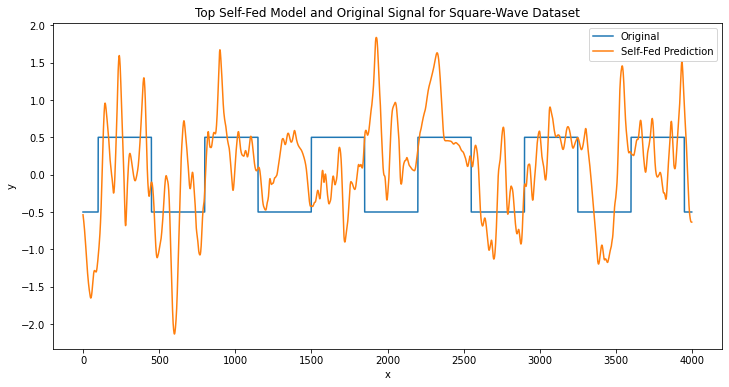

transient  =  1000
rhos  =  1.2
reg  =  0.01
lis  =  0.1
iss  =  1.0
con  =  0.2
Nr  =  100
Nl  =  2
.sampling  =  1
self_fed_MSE =  0.4527520016037838
signal_fed_MSE =  0.044738277384583





In [152]:
model_comparison(top_models, 'Self')

Model number:  1716


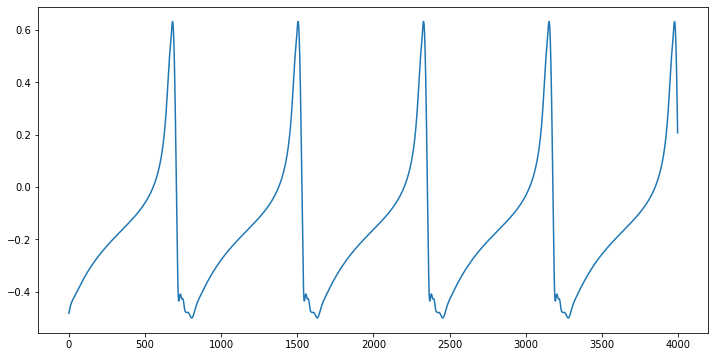

transient  =  1000
rhos  =  1.0
reg  =  10.0
lis  =  0.2
iss  =  1.0
con  =  0.5
Nr  =  10
Nl  =  10
.sampling  =  1
self_fed_MSE =  0.3586863116646003
signal_fed_MSE =  0.0057959680926629





In [153]:
multi_plot(med_fed_std) # top_models = [1930, 1756, 1716, 1427, 722, 257]

In [244]:
#multi_plot(peaked)

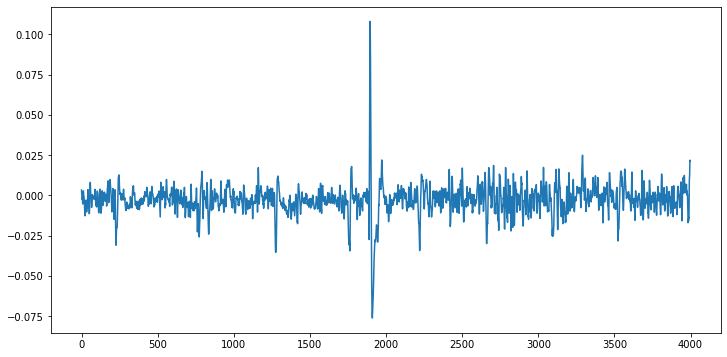

In [252]:
# for i in range(100):
#     plt.plot(signal_fed_mat[i])
plt.plot(signal_fed_mat[722])
plt.show()

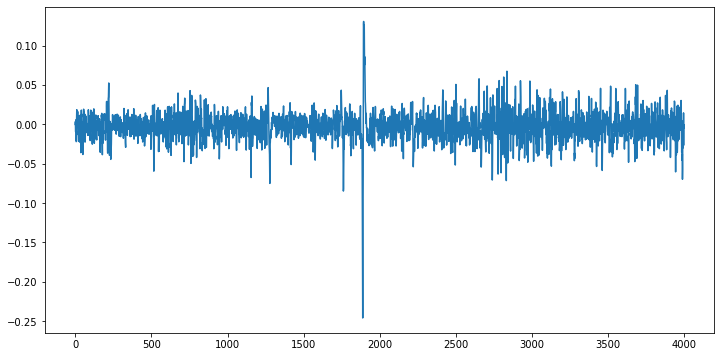

In [246]:
# for i in range(1):
#     plt.plot(orig_signal_mat[i])
plt.plot(orig_signal_mat[0])
plt.show()

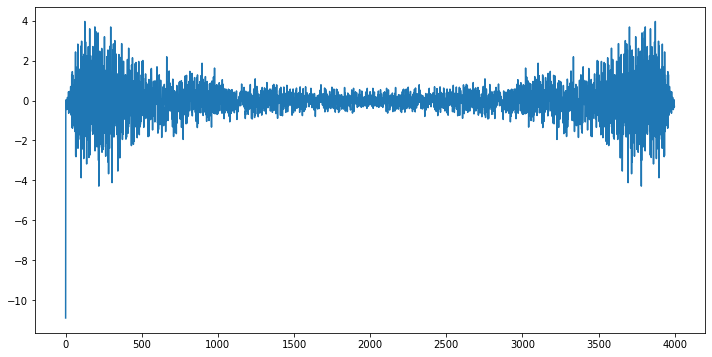

In [247]:
np.fft.fft(orig_signal_mat[i]).shape
plt.plot(np.fft.fft(orig_signal_mat[i]))
plt.show()

In [248]:
# print("hello")
# rho_sweep = results.loc[results['rhos'] == 1]
# reg_sweep = rho_sweep.loc[rho_sweep['reg'] == 1]
# lis_sweep = reg_sweep.loc[reg_sweep['lis'] == .1]
# iss_sweep = lis_sweep.loc[lis_sweep['iss'] == 1]
# Nr_sweep = iss_sweep.loc[iss_sweep['Nr'] == 100]
# con_sweep = Nr_sweep.loc[Nr_sweep['con'] == .2]
# Nl_sweep = con_sweep.loc[con_sweep['Nl'] == 10].reset_index()
# sweep_check = Nr_sweep["index"]